# 1. Quantum States and Qubits

In quantum mechanics we call the column vectors ***kets*** and the row vectors ***bras***. Together they make up ***bra-ket*** notation. Any ket `|a⟩` has a corresponding bra `⟨a|`, and we convert between them using the conjugate transpose.

In [1]:
# imports, baseline
import warnings
from math import sqrt, pi

import matplotlib.cbook
import numpy as np
from IPython.display import display
from qiskit import QuantumCircuit, Aer, assemble
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector
from qiskit_textbook.widgets import plot_bloch_vector_spherical
# plot_bloch_vector(), as input only takes cartesian coordinates; as output s output does graph the Bloch sphere
# plot_bloch_vector_spherical(), does the conversion between cartesian coordinates and spherical coordinates. As input takes spherical coordinates; as output does graph the Bloch sphere
# plot_bloch_multivector, as input it takes a statevector; as output does graph the Bloch sphere

# https://stackoverflow.com/questions/24502500/python-matplotlib-getting-rid-of-matplotlib-mpl-warning
#warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# 1.1 Introduction

In [2]:
from qiskit_textbook.widgets import binary_widget
binary_widget(nbits=5)

HTML(value='<pre>Binary   Decimal\n 00000 = 0</pre>')

In [3]:
from IPython import display
display.Image(url='https://qiskit.org/textbook/ch-states/images/bloch.png')

# 1.2 The Atoms of Computation

## 1.2.3. Your first quantum circuit


In a circuit, we typically need to do three jobs: 
* First, encode the input, 
* then do some actual computation, 
* and finally extract an output.

For your first quantum circuit, we'll focus on the last of these jobs.

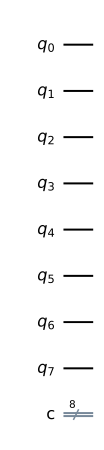

In [4]:
# Start by creating a quantum circuit with eight qubits and eight outputs.
n = 8
n_q = n   # qubits in the circuit
n_b = n   # bits (classical) we will want to extracts from the circuit
qc_output = QuantumCircuit(n_q, n_b, name='my quantum circuit')
qc_output.draw(output='mpl')

These are the instructions in the QuantumCircuit: 

OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg c[8];
creg meas[8];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7];
measure q[0] -> meas[0];
measure q[1] -> meas[1];
measure q[2] -> meas[2];
measure q[3] -> meas[3];
measure q[4] -> meas[4];
measure q[5] -> meas[5];
measure q[6] -> meas[6];
measure q[7] -> meas[7];



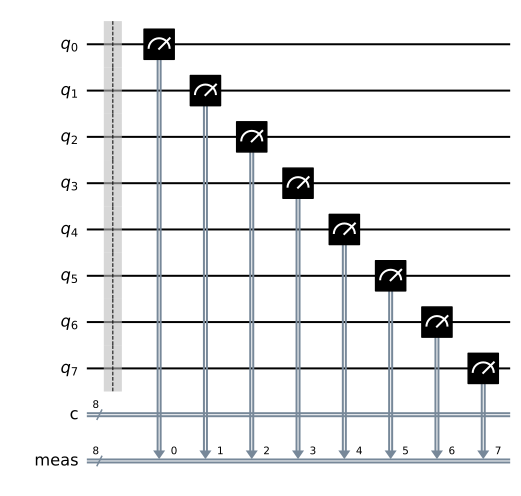

In [5]:
# The extraction of outputs in a quantum circuit is done using an operation called measure.
# Each measurement tells a specific qubit to give an output to a specific output bit.

# The command qc.measure(j,j) adds a measurement to our circuit qc that tells qubit j to write an output to bit j.
#for j in range(n):
#    qc_output.measure(j,j)
# this is the same
qc_output.measure_all()

#The function qasm, part of the QuantumCircuit class, returns a string that contains all of the instructions stored in a QuantumCircuit.
print('These are the instructions in the QuantumCircuit: \n')
print(qc_output.qasm())
qc_output.draw()

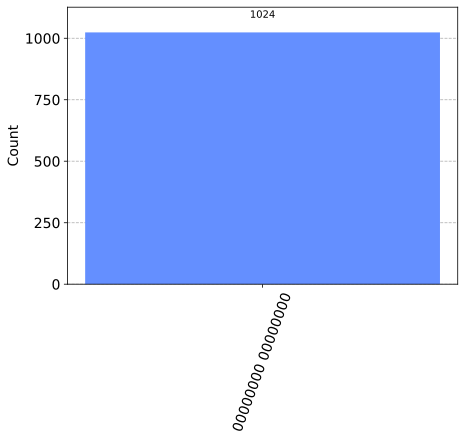

In [6]:
# Run the circuit many times and plotting the results in a histogram. 

# The reason for running many times and showing the result as a histogram is because quantum computers may have some randomness in their results. 

# this is the simulator we'll use
sim = Aer.get_backend('qasm_simulator') # one type of simulator
#sim = Aer.get_backend('aer_simulator') # another type of simulator
# this turns the circuit into an object our backend can run
qobj = assemble(qc_output)

# run the experiment and get the result from that experiment
#result = sim.run(qobj).result()
result = sim.run(qc_output).result()    # in later versions of qiskit there is no need to create the object first.
# from the results, we get a dictionary containing the number of times (counts) each result appeared
counts = result.get_counts()

# and display it on a histogram
plot_histogram(counts)

## 1.2.4. Example: Creating an Adder Circuit 

### 1.2.4.1 Encoding an input 

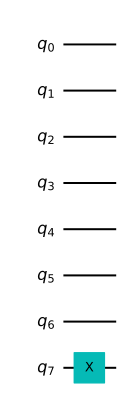

In [7]:
# For now, we ONLY SPECIFY the number of QUBITS.
# how will do the bits?
qc_encode = QuantumCircuit(n)
qc_encode.x(7)
#qc_encode.barrier()
qc_encode.draw()

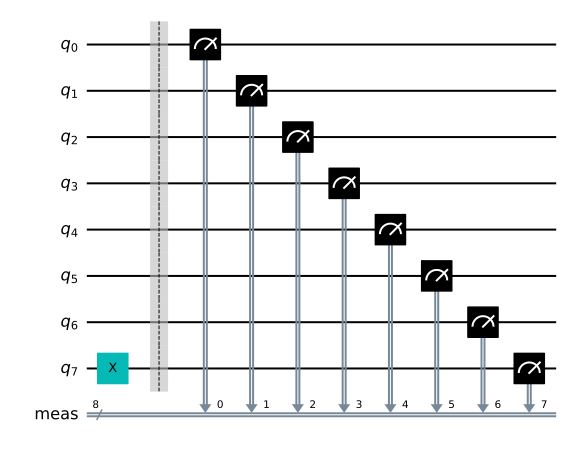

In [8]:
# Adding the two circuits using qc_encode + qc_output creates a new circuit
#qc = qc_encode + qc_output
#qc.draw()
# The bit we flipped, which comes from qubit 7, it is shown on the far right of the grap, but lives on the far left of the bit string. This is because Qiskit numbers the bits in a string from right to left. 

# Extracting results can be done using the circuit we have from before: qc_output.
qc_encode.measure_all()
qc_encode.draw()

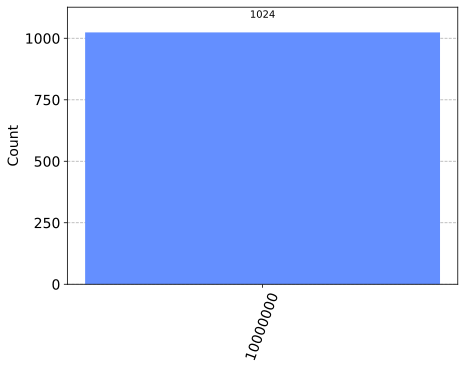

In [9]:
# Now we can run the combined circuit and look at the results.
#qobj = assemble(qc)
#counts = sim.run(qobj).result().get_counts()
#plot_histogram(counts)

# Now we can run the combined circuit and look at the results.
sim = Aer.get_backend('aer_simulator') 
result = sim.run(qc_encode).result()
counts = result.get_counts()
plot_histogram(counts)

### 1.2.4.3 Adding with Qiskit

Will do a ***half-adder***.

0+0 = 00 (in decimal, this is 0+0=0)  
0+1 = 01 (in decimal, this is 0+1=1)  
1+0 = 01 (in decimal, this is 1+0=1)  
1+1 = 10 (in decimal, this is 1+1=2)  

In [10]:
display.Image(url='https://qiskit.org/textbook/ch-states/images/half-adder.svg')

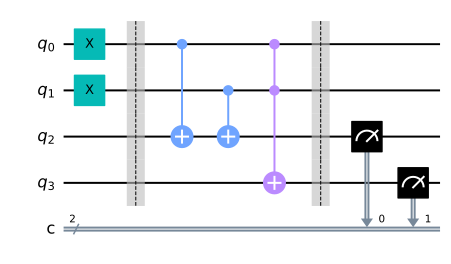

In [11]:
qc_ha = QuantumCircuit(4,2)
#
# ENCODE INPUTS
#
qc_ha.x(0) # For a=0, remove this line. For a=1, leave it.
qc_ha.x(1) # For b=0, remove this line. For b=1, leave it.
qc_ha.barrier()

#
# COMPUTE, OPERATIONS (GATES)
#
# QUBIT 2, use CNOTS to write both qubit 0 and 1 into qubit 2
# that writing results in a XOR of the inputs on qubit 2
qc_ha.cx(0,2)   # CNOT here yields 1 in qubit 2
qc_ha.cx(1,2)   # CNOT here yields 1 in qubit 2
# QUBIT 3, use Toffoli
# if both input are 1, then we want a 1
# if both input are NOT 1, then we want a 0
qc_ha.ccx(0,1,3)
qc_ha.barrier()

#
# EXTRACT OUTPUTS, MEASURE
#
qc_ha.measure(2,0)  # extract XOR value to bit 0
qc_ha.measure(3,1)  # extract Toffoli (AND) value to bit 1

# View
qc_ha.draw()

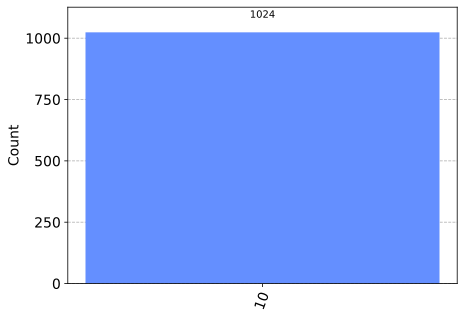

In [12]:
# Execute the circuit a number of times to overcome randomness in the results
qobj = assemble(qc_ha)
counts = sim.run(qobj).result().get_counts()
plot_histogram(counts)

In [13]:
# version inforamation
import qiskit.tools.jupyter
%qiskit_version_table

# 1.3 Representing Qubit States

### 1.3 Exploring Qubits with Qiskit

In [14]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi

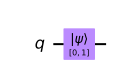

In [15]:
# Create a quantum circuit with one qubit
# QuantumCircuit object to store our circuits, this is essentially a list of the quantum operations on our circuit and the qubits they are applied to.
qc = QuantumCircuit(1)  # create quantum circuit with ONE qubit

# Define initial_state as |1⟩
# |ψ⟩ = 0|0⟩ + 1|1⟩
# The sum of amplitudes-squared must equal one.
initial_state = [0,1]

# Apply initialisation operation to the 0th qubit
qc.initialize(initial_state, 0) # is the same than doing this -> qc.x(0) 

# View the circuit
qc.draw()

In [16]:
# use one of Qiskit’s simulators to view the state the qubit.

# define the simulator to use
svsim = Aer.get_backend('statevector_simulator')

# Create a Qobj from the circuit for the simulator to run
qobj = assemble(qc)     

# To get the results from our circuit, we use execute to run our circuit, giving the circuit and the backend as arguments. 
# Do the simulation and return the result
result = svsim.run(qobj).result()

# from result, we can then get the final statevector using .get_statevector():
out_state = result.get_statevector()

# Display the output state vector
print(out_state)

Statevector([0.+0.j, 1.+0.j],
            dims=(2,))


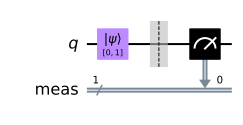

In [17]:
# measure our qubit as we would in a real quantum computer and see the result:
qc.measure_all()
qc.draw()

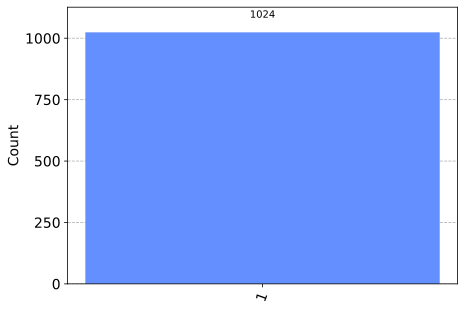

In [18]:
# This time, instead of the statevector we will get the counts for the 0 and 1 results using .get_counts():
qobj = assemble(qc)
result = svsim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

### 4 The Observer Effect 

Now look at a quantum state that is in superposition  
`|ψ⟩ = 1/√2 (i |0⟩ + |1⟩)`


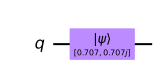

In [19]:
# Create a quantum circuit with one qubit
qc = QuantumCircuit(1)

# Define initial_state as |ψ⟩
# |ψ⟩ = 1/√2 |0⟩ + i 1/√2 |1⟩
# and put the qubit in the initial state
initial_state = [1/sqrt(2),1j/sqrt(2)]
#initial_state = [1/sqrt(2)+0.j,0.+1.j/sqrt(2)]
qc.initialize(initial_state, 0)

# View
qc.draw()

In [20]:
# verify |ψ⟩ = |i⟩ = 1/sqrt(2) (|0⟩ + i |1⟩)
# is initialized in superposition
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
print("Qubit State = " + str(state))

Qubit State = Statevector([0.70710678+0.j        , 0.        +0.70710678j],
            dims=(2,))


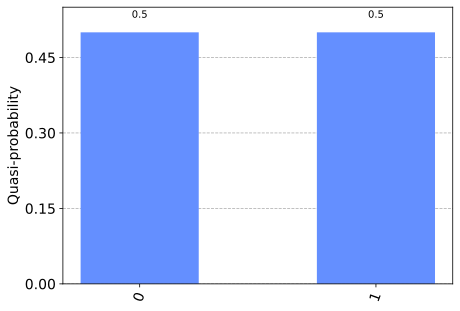

In [21]:
# see we have equal probability of measuring either |0⟩ or |1⟩.
# To explain this, we need to talk about measurement.
results = svsim.run(qobj).result().get_counts()
plot_histogram(results)

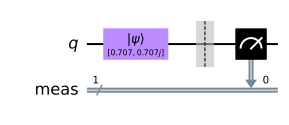

In [22]:
# and ONCE WE MEASURE, the state will collapse and be either 0 or 1
qc.measure_all()
qc.draw()

In [23]:
# When we simulate this entire circuit, we can see that one of the amplitudes is always 0:
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
print("State of Measured Qubit = " + str(state))

# You can re-run this cell a few times to reinitialise the qubit and measure it again. 
# You will notice that either outcome is equally probable, but that the state of the qubit is never a superposition of |0⟩ and |1⟩.
# Somewhat interestingly, the global phase on the state |0⟩ survives, but since this is global phase, we can never measure it on a real quantum computer.



State of Measured Qubit = Statevector([1.+0.j, 0.+0.j],
            dims=(2,))


Qubit State = Statevector([0.+0.57735027j, 0.+0.81649658j],
            dims=(2,))


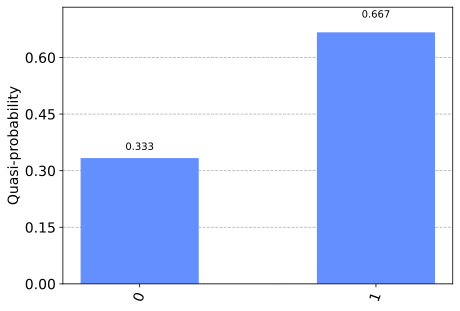

In [24]:
# Exercise 
# Create a state vector that will give a 1/3 probability of measuring |0⟩
# Create a different state vector that will give the same measurement probabilities
# Verify that the probability of measuring |1⟩ for these two states is 2/3


# Create a quantum circuit with one qubit
qc = QuantumCircuit(1)

# Define initial_state as |ψ⟩
# |ψ⟩ = x |0⟩ + y |1⟩
initial_state = [1/sqrt(3),sqrt(2/3)]
initial_state = [1j/sqrt(3),1j * sqrt(2/3)]
#initial_state = [1/sqrt(2)+0.j,0.+1.j/sqrt(2)]

# and put the qubit in the initial state
qc.initialize(initial_state, 0)

# View
#qc.draw()



# verify |ψ⟩ is initialized as expected
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
print("Qubit State = " + str(state))


# see we have equal probability of measuring either |0⟩ or |1⟩.
# To explain this, we need to talk about measurement.
results = svsim.run(qobj).result().get_counts()
plot_histogram(results)


In [25]:
# You can re-run this cell a few times to reinitialise the qubit and measure it again. 
# You will notice that either outcome is equally probable, but that the state of the qubit is never a superposition of |0⟩ and |1⟩.
# Somewhat interestingly, the global phase on the state |0⟩ survives, but since this is global phase, we can never measure it on a real quantum computer.

# Define initial_state as |ψ⟩
# |ψ⟩ = 1/√2 |0⟩ + i 1/√2 |1⟩
initial_state = [1/sqrt(2),1j/sqrt(2)]

svsim = Aer.get_backend('statevector_simulator')

# Create a quantum circuit with one qubit
qc = QuantumCircuit(1)

for i in range(100):
    # put the qubit in the initial state
    qc.initialize(initial_state, 0)

    qc.measure_all()

    qobj = assemble(qc)
    state = svsim.run(qobj).result().get_statevector()
    print("State of Measured Qubit = " + str(state))

State of Measured Qubit = Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
State of Measured Qubit = Statevector([0.+0.j, 0.+1.j],
            dims=(2,))
State of Measured Qubit = Statevector([0.+0.j, 0.+1.j],
            dims=(2,))
State of Measured Qubit = Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
State of Measured Qubit = Statevector([0.+0.j, 0.+1.j],
            dims=(2,))
State of Measured Qubit = Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
State of Measured Qubit = Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
State of Measured Qubit = Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
State of Measured Qubit = Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
State of Measured Qubit = Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
State of Measured Qubit = Statevector([0.+0.j, 0.+1.j],
            dims=(2,))
State of Measured Qubit = Statevector([1.+0.j, 0.+0.j],
            dims=(2,))
State of Measured Qubit = Statevector([1.+0.j, 0.+0.

### 3. The Bloch Sphere

### 3.2 Visually Representing a Qubit State

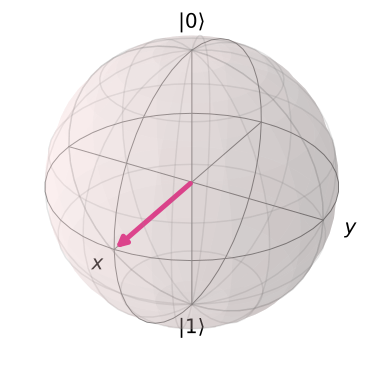

In [26]:
from qiskit_textbook.widgets import plot_bloch_vector_spherical
# this is the state |+>
coords = [pi/2,0,1] # [Theta, Phi, Radius]
plot_bloch_vector_spherical(coords) # Bloch Vector with spherical coordinates

In [27]:
from qiskit_textbook.widgets import bloch_calc
bloch_calc()

HTML(value='<pre></pre>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xf4\x00\x00\x01\xf4\x08\x06\x00\x00\x00\xcb\xd6\…

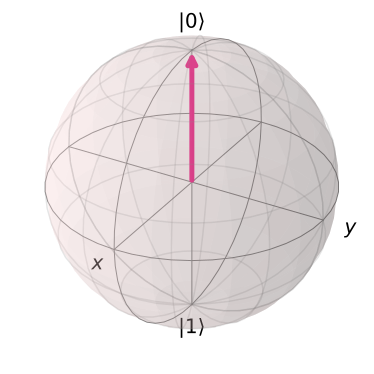

In [28]:
# represent state |0⟩
# theta = 0
# phi = 0
# Cartesian Bloch Vector = [0, 0, 1.0]
coords = [0,0,1] # [Theta, Phi, Radius]
plot_bloch_vector_spherical(coords) # Bloch Vector with spherical coordinates


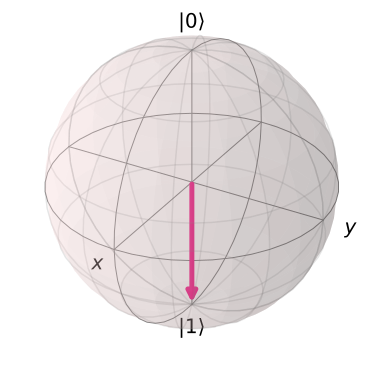

In [29]:
# represent state |1⟩
# theta = pi
# phi = 0
# Cartesian Bloch Vector = [0, 0, -1.0]
coords = [pi,0,1] # [Theta, Phi, Radius]
plot_bloch_vector_spherical(coords) # Bloch Vector with spherical coordinates


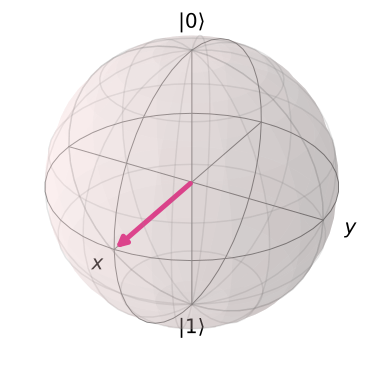

In [30]:
# represent state |+⟩ = 1/sqrt(2)(|0⟩ + |1⟩)
# theta = pi
# phi = 0
# Cartesian Bloch Vector = [1.0, 0, 0]
coords = [pi/2,0,1] # [Theta, Phi, Radius]
plot_bloch_vector_spherical(coords) # Bloch Vector with spherical coordinates

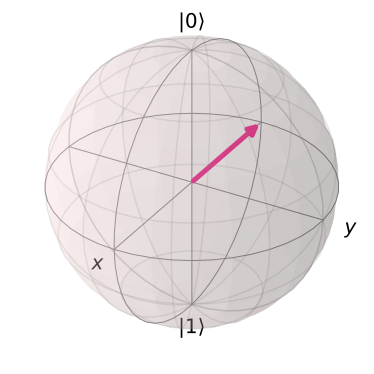

In [31]:
# represent state |-⟩ = 1/sqrt(2)(|0⟩ - |1⟩)
# theta = 3/2 * pi
# phi = 0
# Cartesian Bloch Vector = [-1.0, 0, 0]
coords = [3*pi/2,0,1] # [Theta, Phi, Radius]
plot_bloch_vector_spherical(coords) # Bloch Vector with spherical coordinates


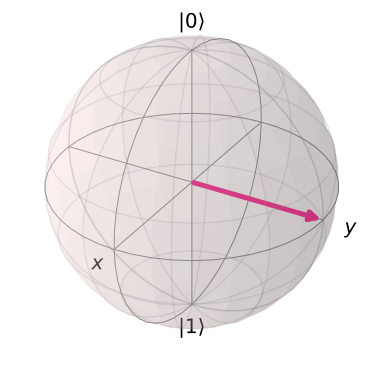

In [32]:
# represent state |i⟩ = 1/sqrt(2)(|0⟩ + j |1⟩)
# theta = pi/2
# phi = pi/2
# Cartesian Bloch Vector = [0, 1, 0]
coords = [pi/2,pi/2,1] # [Theta, Phi, Radius]
plot_bloch_vector_spherical(coords) # Bloch Vector with spherical coordinates

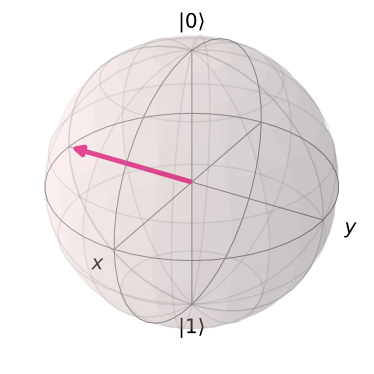

In [33]:
# represent state |-i⟩ = 1/sqrt(2)(|0⟩ - j |1⟩)
# theta = pi/2
# phi = 3/2pi
# Cartesian Bloch Vector = [0, -1.0, 0]
coords = [pi/2,3/2 * pi,1] # [Theta, Phi, Radius]
plot_bloch_vector_spherical(coords) # Bloch Vector with spherical coordinates

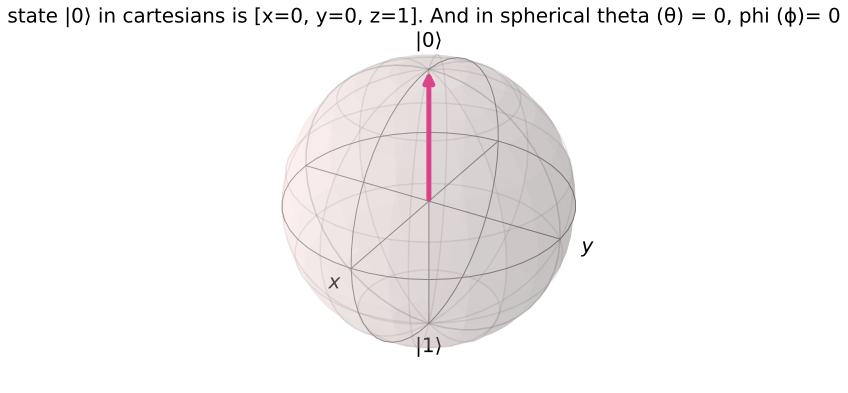

In [34]:
from qiskit.visualization import plot_bloch_vector
# this is the state |0⟩
coords = [0,0,1] # [x, y, z]
title = 'state |0⟩ in cartesians is [x=0, y=0, z=1]. And in spherical theta (θ) = 0, phi (ϕ)= 0'
plot_bloch_vector(coords, title=title) # Bloch Vector with Cartesian coordinates

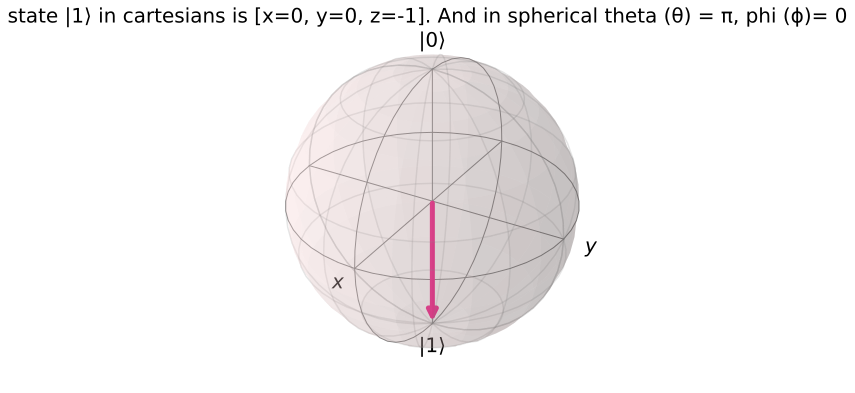

In [35]:
# this is the state |1⟩
coords = [0,0,-1] # [x, y, z]
title = 'state |1⟩ in cartesians is [x=0, y=0, z=-1]. And in spherical theta (θ) = π, phi (ϕ)= 0'
plot_bloch_vector(coords, title=title) # Bloch Vector with Cartesian coordinates

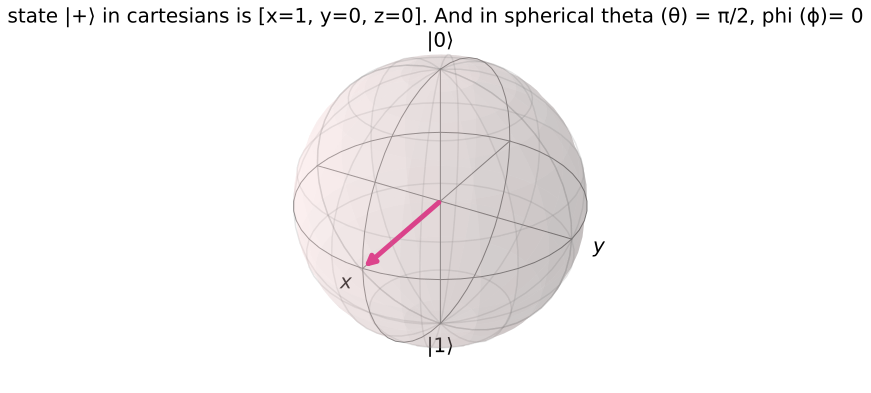

In [36]:
# this is the state |+⟩
coords = [1,0,0] # [x, y, z]
title = 'state |+⟩ in cartesians is [x=1, y=0, z=0]. And in spherical theta (θ) = π/2, phi (ϕ)= 0'
plot_bloch_vector(coords, title=title) # Bloch Vector with Cartesian coordinates

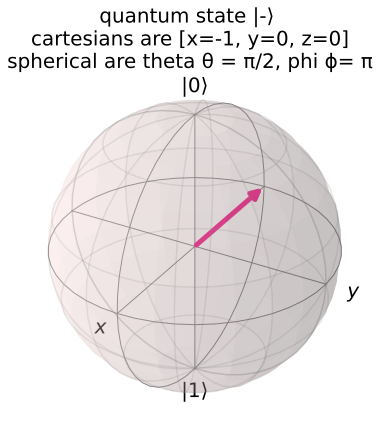

In [37]:
# this is the state |->
coords = [-1,0,0] # [x, y, z]
title = 'quantum state |-⟩ \ncartesians are [x=-1, y=0, z=0]\nspherical are theta θ = π/2, phi ϕ= π'
plot_bloch_vector(coords, title=title) # Bloch Vector with Cartesian coordinates

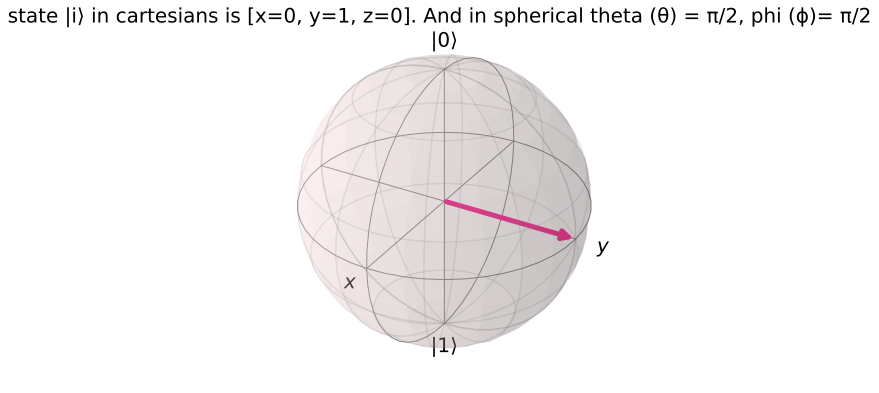

In [38]:
# this is the state |i⟩
coords = [0,1,0] # [x, y, z]
title = 'state |i⟩ in cartesians is [x=0, y=1, z=0]. And in spherical theta (θ) = π/2, phi (ϕ)= π/2'
plot_bloch_vector(coords, title=title) # Bloch Vector with Cartesian coordinates

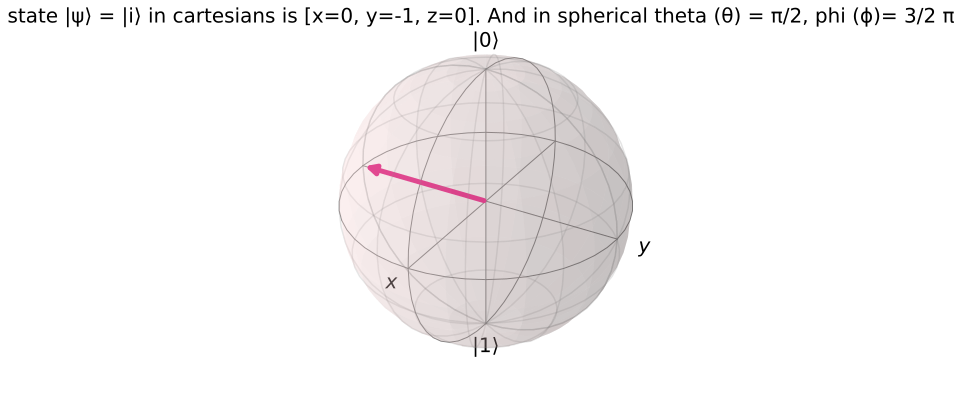

In [39]:
# this is the state |-i⟩
coords = [0,-1,0] # [x, y, z]
title = 'state |ψ⟩ = |i⟩ in cartesians is [x=0, y=-1, z=0]. And in spherical theta (θ) = π/2, phi (ϕ)= 3/2 π'
plot_bloch_vector(coords, title=title) # Bloch Vector with Cartesian coordinates

In [40]:
import qiskit.tools.jupyter
%qiskit_version_table

# 1.4 Single Qubit Gates

## 1.4.1 The Pauli Gates 

In [45]:
from qiskit import QuantumCircuit, assemble, Aer
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram
sim = Aer.get_backend('aer_simulator')

### 1.1 The X-Gate

the X-gate switches the **amplitudes** of the states |0⟩ and |1⟩.

We can think of this gate as a rotation by π radians around the x-axis of the Bloch sphere. The X-gate is also often called a NOT-gate, referring to its classical analogue.



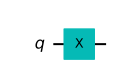

In [47]:
# Let's do an X-gate on a |0> qubit
qc = QuantumCircuit(1)
qc.x(0)
qc.draw()

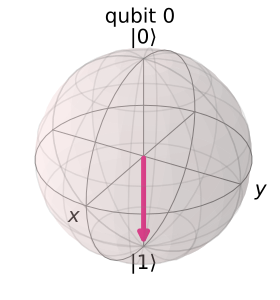

In [48]:
# Let's see the result of the above circuit. 
# Note: Here we use plot_bloch_multivector() which takes a qubit's statevector instead of the Bloch vector.
qc.save_statevector()
qobj = assemble(qc)
state = sim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

### 1.2 The Y & Z-gates

They respectively perform rotations by π around the y and z-axis of the Bloch sphere.

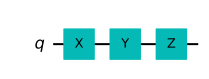

In [46]:
# Let's do an Y-gate and Z-gate on a |0⟩ qubit
qc = QuantumCircuit(1)
qc.x(0) # Do X-gate on qubit 0
#qc.draw()
qc.y(0) # Do Y-gate on qubit 0
qc.z(0) # Do Z-gate on qubit 0
qc.draw()

In [50]:
# Widget that displays a qubit’s state on the Bloch sphere, pressing one of the buttons will perform the gate on the qubit
# Run the code in this cell to see the widget
from qiskit_textbook.widgets import gate_demo
gate_demo(gates='pauli')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xe0\x00\x00\x01\xe0\x08\x06\x00\x00\x00}\xd4\xbe…

the eigenstates of the Y-gate. These are called:
|↺⟩, |↻⟩

### Quick Exercise #1. Verify that: `|+⟩` and `|−⟩` are in fact eigenstates of the X-gate.

In [51]:
# |+⟩ = 1/√2 (|0⟩ + |1⟩)
svsim = Aer.get_backend('statevector_simulator') # Tell Qiskit how to simulate our circuit
qc = QuantumCircuit(1)  # Create a quantum circuit with one qubit
initial_state = [1/sqrt(2),1/sqrt(2)]    # Define initial_state as |+⟩
initial_state = [1/sqrt(2),-1/sqrt(2)]   # Define initial_state as |-⟩

# do not apply any gates and observe the state
qc.initialize(initial_state, 0) # Apply initialisation operation to the 0th qubit
qobj = assemble(qc)     # Create a Qobj from the circuit for the simulator to run
result = svsim.run(qobj).result() # Do the simulation and return the result
qc.draw()
out_state = result.get_statevector()
print(out_state) # Display the output state vector

# Apply the X gate and observe the state
# Note: we can only do this in a simulator. In a real computer the state would collapse.
qc.x(0)
qobj = assemble(qc)     # Create a Qobj from the circuit for the simulator to run
result = svsim.run(qobj).result() # Do the simulation and return the result
qc.draw()
out_state = result.get_statevector()
print(out_state) # Display the output state vector

Statevector([ 0.70710678+0.j, -0.70710678+0.j],
            dims=(2,))
Statevector([-0.70710678+0.j,  0.70710678+0.j],
            dims=(2,))


### Result

`X|+⟩ =  |+⟩`, => `|+⟩` is eigenstate of `X` and its eigenvalue (`λ`) is `1`  
`X|-⟩ = -|-⟩`, => `|-⟩` is eigenstate of `X` and its eigenvalue (`λ`) is `-1`

### Quick Exercise #4. Find the eigenstates of the Y-gate, and their co-ordinates on the Bloch sphere.

In [43]:
svsim = Aer.get_backend('statevector_simulator') # Tell Qiskit how to simulate our circuit
qc = QuantumCircuit(1)  # Create a quantum circuit with one qubit
initial_state = [1,0]   # Define initial_state as |0⟩
initial_state = [0,1]   # Define initial_state as |01⟩
#initial_state = [1/sqrt(2),1/sqrt(2)]   # Define initial_state as |+⟩
#initial_state = [1/sqrt(2),-1/sqrt(2)]   # Define initial_state as |-⟩
#initial_state = [1/sqrt(2),1j/sqrt(2)]   # Define initial_state as |+i⟩
#initial_state = [1/sqrt(2),-1j/sqrt(2)]   # Define initial_state as |-i⟩

qc.initialize(initial_state, 0) # Apply initialisation operation to the 0th qubit
qobj = assemble(qc)     # Create a Qobj from the circuit for the simulator to run
result = svsim.run(qobj).result() # Do the simulation and return the result
qc.draw()
out_state = result.get_statevector()
print(out_state) # Display the output state vector

qc.y(0)
qobj = assemble(qc)     # Create a Qobj from the circuit for the simulator to run
result = svsim.run(qobj).result() # Do the simulation and return the result
qc.draw()
out_state = result.get_statevector()
print(out_state) # Display the output state vector

# Y|i⟩ = |i⟩, => |i⟩ is eigenstate of Y and its eigenvalue is 1
# Y|-i⟩ = -|-i⟩, => |-i⟩ is eigenstate of Y and its eigenvalue is -1

Statevector([0.+0.j, 1.+0.j],
            dims=(2,))
Statevector([0.-1.j, 0.+0.j],
            dims=(2,))


### Result

`Y| i⟩ =  |i⟩`,  => `| i⟩` is eigenstate of Y and its eigenvalue (`λ`) is `1`  
`Y|-i⟩ = -|-i⟩`, => `|-i⟩` is eigenstate of Y and its eigenvalue (`λ`) is `-1`

## 1.4.3. The Hadamard Gate

The Hadamard gate (H-gate) allows us to move away from the poles of the Bloch sphere and create a superposition of `|0⟩` and `|1⟩`. 

Performs the transformations below:

```math
H|0⟩ = |+⟩
H|1⟩ = |−⟩
```

This can be thought of as a rotation around the Bloch vector `[1,0,1]` (the line between the x & z-axis), or as transforming the state of the qubit between the X and Z bases.

### Quick Exercise #1. Write the H-gate as the outer products of vectors |0⟩, |1⟩, |+⟩ and |−⟩.

### Quick Exercise #2. Show that applying the sequence of gates: `HZH`, to any qubit state is equivalent to applying an `X`-gate.
```math
         Z       H    
1/√2 | 1   0 | 1   1 |   1/√2  |  1  1 |
     | 0  -1 | 1  -1 | =       | -1  1 |

         H              ZH
1/√2 | 1   1 | 1/√2 |  1  1 | = | 0  1 |
     | 1  -1 |      | -1  1 |   | 1  0 |

HZH = | 0  1 |
      | 1  0 |
    
X =   | 0  1 |
      | 1  0 |
```
Hence `HZH` = `X`

### Quck exercise #3. Find a combination of X, Z and H-gates that is equivalent to a Y-gate (ignoring global phase).

## 1.4.5 the Rϕ-gate

The Rϕ-gate is parametrised, that is, it needs a number (ϕ) to tell it exactly what to do. The Rϕ-gate performs a rotation of ϕ around the Z-axis direction (and as such is sometimes also known as the Rz-gate). 

You may notice that the Z-gate is a special case of the Rϕ-gate, with ϕ = π. In fact there are three more commonly referenced gates we will mention in this chapter, all of which are special cases of the Rϕ-gate:



## 1.4.6 The I, S and T-gates

### 1.4.6.1 The I-gate

First comes the I-gate (aka ‘Id-gate’ or ‘Identity gate’). This is simply a gate that does nothing.

Applying the identity gate anywhere in your circuit should have no effect on the qubit state, so it’s interesting this is even considered a gate. There are two main reasons behind this, one is that it is often used in calculations, for example: proving the X-gate is its own inverse:

`I = XX`
 
The second, is that it is often useful when considering real hardware to specify a ‘do-nothing’ or ‘none’ operation.



#### Quick Exercise. What are the eigenstates of the I-gate?

##### Response

Each and all statevectors, because for any statevector `v`, `Iv = v`.

### 1.4.6.2 The S-gate

The next gate to mention is the S-gate (sometimes known as the `√Z-gate`), this is an Rϕ-gate with `ϕ = π/2`. It does a quarter-turn around the Bloch sphere. It is important to note that unlike every gate introduced in this chapter so far, the S-gate is not its own inverse! As a result, you will often see the `S†-gate`, (also “S-dagger “Sdg” or √Z†-gate). The S†-gate is clearly an Rϕ-gate with `ϕ = −π/2`.

The name "`√Z-gate`" is due to the fact that two successively applied S-gates has the same effect as one Z-gate:  
`SS|q⟩ = Z|q⟩`

### 1.4.6.3 The T-gate 

The T-gate is an Rϕ-gate with

`ϕ = π/4`

As with the S-gate, the T-gate is sometimes also known as the `√4Z-gate`.

## 1.4.7 General U-gates

As we saw earlier, the I, Z, S & T-gates were all special cases of the more general Rϕ-gate. In the same way, the U3-gate is the most general of all single-qubit quantum gates. It is a parametrised gate of the form:

`U3(θ,ϕ,λ)` = see the matrix [here](https://qiskit.org/textbook/ch-states/single-qubit-gates.html#7.-General-U-gates--)

Every gate in this chapter could be specified as `U3(θ,ϕ,λ)`, but it is unusual to see this in a circuit diagram, possibly due to the difficulty in reading this.

Qiskit provides `U1` and `U2` gates, which are specific cases of the `U3`-gate in which `θ = ϕ = 0`, and `θ = π/2` respectively. You will notice that the `U1`-gate is equivalent to the `Rϕ-gate`.

`U3(π/2,ϕ,λ) = U2`  
`U3(0,0,λ) = U1`


Before running on real IBM quantum hardware, all single-qubit operations are compiled down to `U1` ,`U2` and `U3`. For this reason they are sometimes called the ***physical gates***.



It should be obvious from this that there are an infinite number of possible gates, and that this also includes Rx and Ry-gates, although they are not mentioned here. It must also be noted that there is nothing special about the Z-basis, except that it has been selected as the standard computational basis. That is why we have names for the S and T-gates, but not their X and Y equivalents (e.g. √X and 4√Y).

In [44]:
# to check the version installed in your computer:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.22.2', 'qiskit-aer': '0.11.1', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.39.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}